# **Cargar API de Kaggle**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: 

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"edgalmuoz","key":"38cd2c2dabb01b0ca6a558e7441a748e"}'}

# **Configurar la autenticación de la API de Kaggle y poder descargar datasets**

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# **Descargar un archivo ZIP con los datos de entrenamiento y prueba.**

In [4]:
!kaggle competitions download -c dogs-vs-cats

 97% 788M/812M [00:03<00:00, 294MB/s]
100% 812M/812M [00:03<00:00, 274MB/s]


# **Extrae el contenido del dataset completo en el directorio actual**

In [5]:
!unzip -qq dogs-vs-cats.zip

# **Extrae solo los datos de entrenamiento**

In [6]:
!unzip -qq train.zip

# **Separar las imágenes en conjuntos de entrenamiento, validación y prueba.**

In [7]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

# **Construcción del modelo**

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# **Arquitectura de la CNN**

In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

# **Configurando el modelo para el entrenamiento**

In [10]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# **Usando image_dataset_from_directory para leer imágenes**


In [11]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


# **Formas de los datos y las etiquetas generadas por el conjunto de datos**

In [12]:
for data, labels in train_dataset:
    print("data batch shape:", data.shape)
    print("labels batch shape:", labels.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


# **Entrenar el modelo**

In [13]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy: 0.5109 - loss: 0.7835 - val_accuracy: 0.5260 - val_loss: 0.6919
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.5300 - loss: 0.6912 - val_accuracy: 0.5050 - val_loss: 0.6882
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.5461 - loss: 0.7344 - val_accuracy: 0.5080 - val_loss: 0.6900
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.5842 - loss: 0.7034 - val_accuracy: 0.5490 - val_loss: 0.6840
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.6082 - loss: 0.6588 - val_accuracy: 0.6080 - val_loss: 0.6588
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6407 - loss: 0.6347 - val_accuracy: 0.6380 - val_loss: 0.6294
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6612 - loss: 0.6057 - val_accuracy: 0.6580 - val_loss: 0.6513
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.7326 - loss: 0.5684 - val_accuracy: 0.7070 

# **Gráficar la pérdida y la precisión del modelo sobre los datos de entrenamiento y validación**

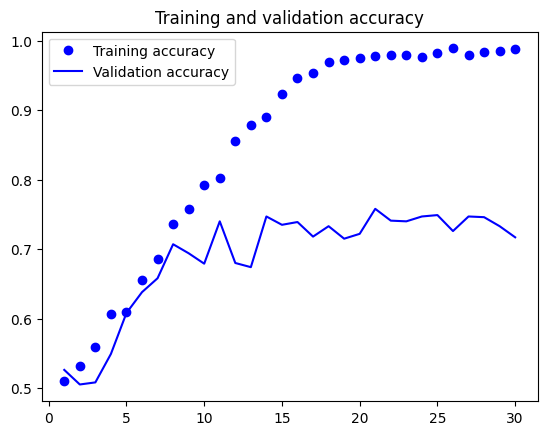

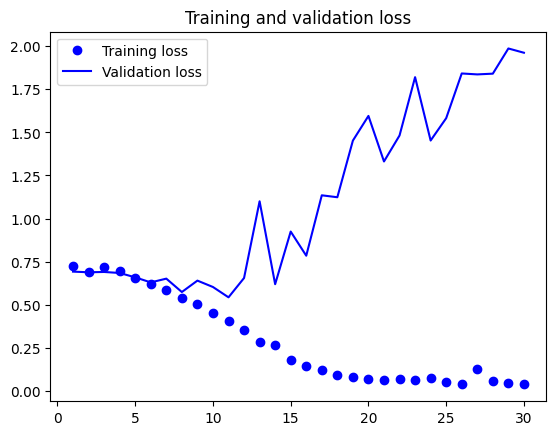

In [14]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# **Evaluación del modelo**

In [15]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.7450 - loss: 0.5802
Test accuracy: 0.732


# **Aumento de datos**

**Definir una etapa de aumento de datos para agregar a un modelo de imagen**

In [16]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Muestra algunas imágenes de entrenamiento aumentadas aleatoriamente**

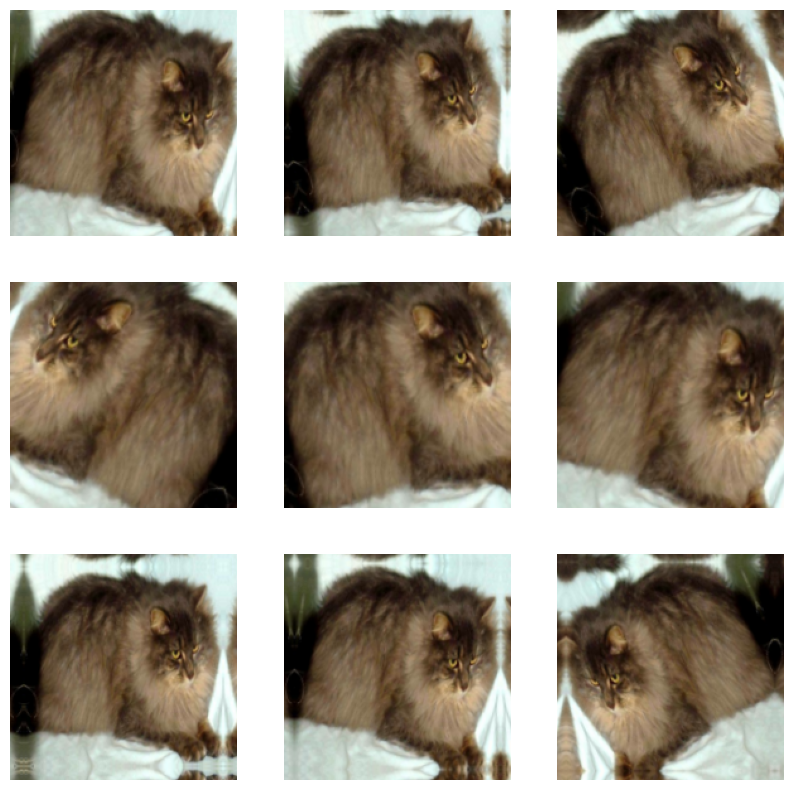

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Contruir y entrenar el modelo**

In [18]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [19]:
callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="convnet_from_scratch_with_augmentation.keras",
save_best_only=True,
monitor="val_loss")
]
history = model.fit(
train_dataset,
epochs=80,
validation_data=validation_dataset,
callbacks=callbacks)

Epoch 1/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.5118 - loss: 0.7204 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.5024 - loss: 0.6936 - val_accuracy: 0.5420 - val_loss: 0.6920
Epoch 3/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.5132 - loss: 0.6924 - val_accuracy: 0.5980 - val_loss: 0.6763
Epoch 4/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.5699 - loss: 0.6873 - val_accuracy: 0.5350 - val_loss: 0.6973
Epoch 5/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.5969 - loss: 0.6660 - val_accuracy: 0.6100 - val_loss: 0.6406
Epoch 6/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.6129 - loss: 0.6582 - val_accuracy: 0.6350 - val_loss: 0.6547
Epoch 7/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.6898 - loss: 0.6948 - val_accuracy: 0.6510 - val_loss: 0.6332
Epoch 8/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.6747 - loss: 0.5923 - val_accuracy: 0.5920 - v

In [20]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7912 - loss: 0.4463
Test accuracy: 0.794


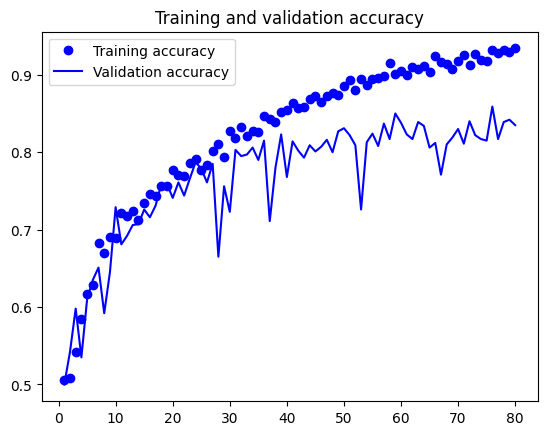

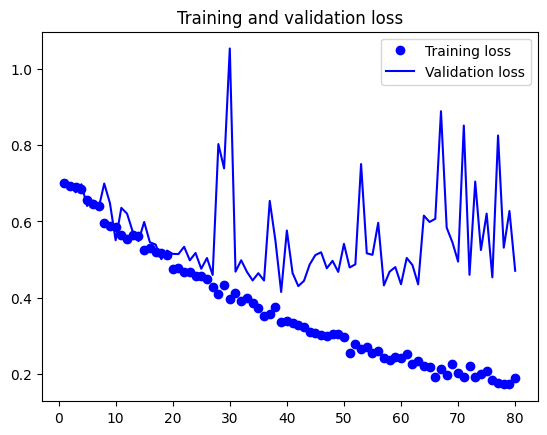

In [21]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# **Aprovechar un modelo entrenado previamente**

## **Extracción de características con un modelo preentrenado**

**Instanciación de la base convolucional VGG16**

In [22]:
from tensorflow import keras
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Arquitectura del model VGG16**

In [23]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

**Extracción rápida de características sin aumento de datos**

In [24]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

**Definición y entrenamiento del clasificador densamente conectado**

In [25]:
from tensorflow.keras import layers
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8777 - loss: 17.7940 - val_accuracy: 0.9570 - val_loss: 6.9848
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9763 - loss: 3.3916 - val_accuracy: 0.9700 - val_loss: 7.3428
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9836 - loss: 1.8153 - val_accuracy: 0.9630 - val_loss: 7.8934
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9918 - loss: 1.0015 - val_accuracy: 0.9750 - val_loss: 4.1580
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9915 - loss: 1.1428 - val_accuracy: 0.9800 - val_loss: 4.2206
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9899 - loss: 1.8515 - val_accuracy: 0.9720 - val_loss: 4.5922
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9990 - loss: 0.0961 - val_accuracy: 0.9730 - val_loss: 5.1348
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9972 - loss: 0.6150 - val_accuracy: 0.9730 - val_lo

**Métricas de entrenamiento y validación**

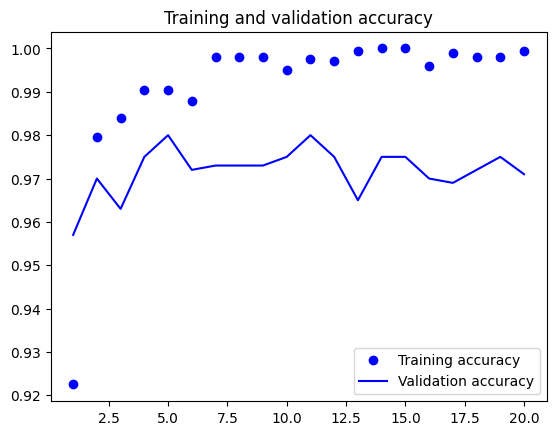

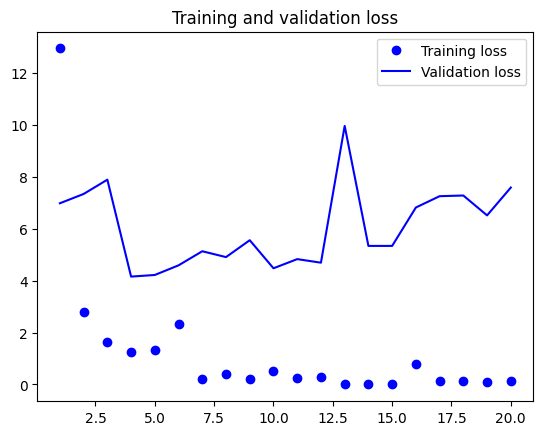

In [26]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

 **Extracción de características con aumento de datos**

**Instanciación y congelación de la base convolucional VGG16**

In [27]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Añadiendo una etapa de ampliación de datos y un clasificador a la base convolucional**

In [28]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


In [29]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 171ms/step - accuracy: 0.8386 - loss: 29.8660 - val_accuracy: 0.9610 - val_loss: 4.7778
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 0.9312 - loss: 8.7837 - val_accuracy: 0.9690 - val_loss: 5.4537
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - accuracy: 0.9501 - loss: 6.4721 - val_accuracy: 0.9660 - val_loss: 6.0309
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9562 - loss: 5.5102 - val_accuracy: 0.9640 - val_loss: 7.4635
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 0.9597 - loss: 5.3023 - val_accuracy: 0.9780 - val_loss: 4.0409
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.9749 - loss: 3.1329 - val_accuracy: 0.9740 - val_loss: 4.0708
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9586 - loss: 5.0003 - val_accuracy: 0.9750 - val_loss: 3.8657
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.9723 - loss: 3.4981 - val_accu

**Gráfica de parámetros**

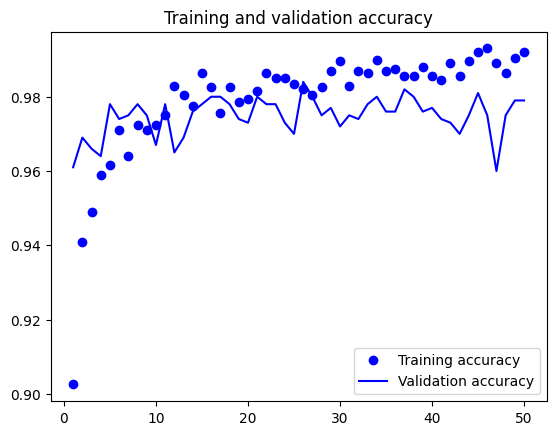

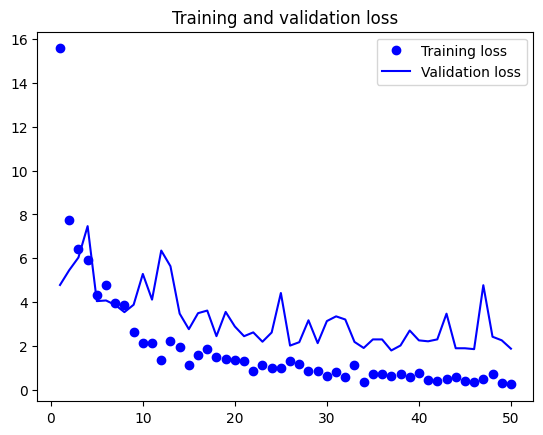

In [30]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluación del modelo**

In [31]:
test_model = keras.models.load_model(
"feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9805 - loss: 1.7891
Test accuracy: 0.979


## **Ajuste Fino con un modelo preentrenado**

**Agregar nuestra red personalizada sobre una red base ya entrenada**

In [32]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

**Congelar la red base**

In [33]:
conv_base.trainable = False

**Entrenar solo la parte agregada**

In [34]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 0.8366 - loss: 39.2241 - val_accuracy: 0.9500 - val_loss: 9.6504
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.9356 - loss: 7.9632 - val_accuracy: 0.9810 - val_loss: 2.8916
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9452 - loss: 7.8278 - val_accuracy: 0.9810 - val_loss: 3.2324
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9597 - loss: 4.9985 - val_accuracy: 0.9750 - val_loss: 6.4845
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 172ms/step - accuracy: 0.9660 - loss: 4.5756 - val_accuracy: 0.9750 - val_loss: 4.1589
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 171ms/step - accuracy: 0.9622 - loss: 4.7058 - val_accuracy: 0.9520 - val_loss: 11.1469
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - accuracy: 0.9630 - loss: 4.1815 - val_accuracy: 0.9750 - val_loss: 6.0643
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.9676 - loss: 3.8333 - val_accu

**Congelar todas las capas menos las ultimas cuatro.**

In [35]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
  layer.trainable = False

**Entrenamos de forma conjunta con las capas superiores**

In [36]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 162ms/step - accuracy: 0.9896 - loss: 1.4069 - val_accuracy: 0.9740 - val_loss: 3.6697
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.9872 - loss: 0.8773 - val_accuracy: 0.9750 - val_loss: 3.8037
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.9868 - loss: 0.7463 - val_accuracy: 0.9810 - val_loss: 2.9189
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - accuracy: 0.9770 - loss: 1.1041 - val_accuracy: 0.9830 - val_loss: 2.5415
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 153ms/step - accuracy: 0.9847 - loss: 0.8309 - val_accuracy: 0.9810 - val_loss: 2.6194
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 0.9871 - loss: 0.7649 - val_accuracy: 0.9820 - val_loss: 2.1526
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.9931 - loss: 0.4177 - val_accuracy: 0.9810 - val_loss: 2.1734
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9918 - loss: 0.5366 - val_accur

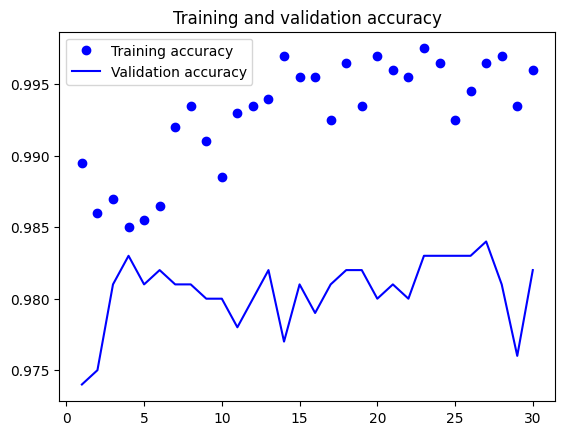

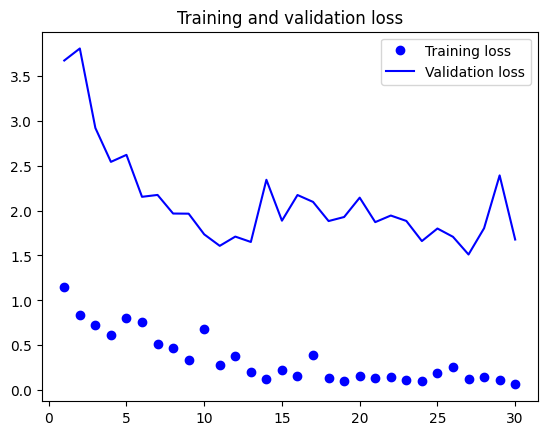

In [37]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [39]:
#test_model = keras.models.load_model(
#"feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.9772 - loss: 1.8302
Test accuracy: 0.978
